# Working with Time-Series Data in a Consistent Bayesian Framework
---

Copyright 2017 Michael Pilosov

Demonstration available at https://www.youtube.com/watch?v=rUIVcl64NXw

### Import Libraries
_(should be 2.7 and 3.x compatible) _

In [1]:
# Mathematics and Plotting
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sstats
from scipy.stats import gaussian_kde as gkde
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 5, 5

# Interactivity
from ipywidgets import *

---
## Defining the Parameter to Observables (PtO) and Quantity of Interest (QoI) maps

---
Consider the Initival Value Problem (IVP)

$$
\begin{cases}
    \dot{u}(t) = -u(t), & t>0 \\
    u(0) = \lambda, & 
\end{cases}
$$

with solution $u(t;\lambda) = \lambda \,e^{-t}$.

Let $0<t_0<t_1<\ldots, t_K$ denote the observation times. 
Given a fixed initial condition (i.e., parameter) $\lambda$, let $y_k$ denote the set of (noisy) observations of the state variable $u(t_k,\lambda)$ for $k=0,1,\ldots, K$. 

We make the standard assumption of an additive error model with independent identically distributed noise, i.e., for each $k=0,1,\ldots,K$ and fixed value of $\lambda$, we assume that the Parameter-to-Observables (PtO) maps are given by

$$
y_k = u(t_k;\lambda) + \epsilon_k, \quad \epsilon_k \sim N(0,\sigma_k). 
$$

Assume that there is a true value of $\lambda$, which we denoted by $\lambda_0$, for which the observations $y_k$ are given for $k=0,1,\ldots,K$.

Then, for any other value of $\lambda$ in the IVP above, we define the Quantity of Interest (QoI) as the **Mean Squared Error (2-norm) between the observations and the model predictions**, i.e., we define the QoI map as

$$
    \boxed{Q(\lambda) := \frac{1}{K+1} \sum_{k=0}^{K} \frac{(u(t_k;\lambda) - y_k) ^ 2}{\sigma_k^2}}
$$

We let $\mathcal{D} := Q(\Lambda)$ denote the space of all possible observations of mean squared error. 


---
## Formulating the Inverse Problem:
---
### Prior Information/Assumptions

* We assume that the true value $\lambda_0$ belongs to the parameter space defined by $\Lambda:= [0, 2]$.


* Prior to the data $\{y_i\}_{i=0}^K$ being available, any value of the parameter $\lambda$ in $\Lambda$ is assumed to be equally likely. In other words, we take $\pi^{prior}_\Lambda(\lambda)$ to be a uniform density.


### The Observed Density

* For the true value of $\lambda_0$, we have that $u(t_k;\lambda_0)-y_k = \epsilon_k$ for each $k$. Thus, the observed density on $\mathcal{D}$, denoted by $\pi^{obs}_{\mathcal{D}}(d)$, is given by a $\frac{1}{K+1}\chi^2_{K+1}$ distribution.

### The Posterior Density

* Let $\pi^{O(prior)}_{\mathcal{D}}(d)$ denote the push-forward of the prior density onto $\mathcal{D}$. Then, the posterior density on $\Lambda$ is given by

$$
    \pi^{post}_\Lambda(\lambda) := \pi^{prior}_\Lambda(\lambda)\frac{\pi^{obs}_{\mathcal{D}}(Q(\lambda))}{\pi^{O(prior)}_{\mathcal{D}}(Q(\lambda))}
$$

---
## The numerical implementation
---
Here, we provide only a few brief remarks on the implementation.
For a step-by-step walkthrough, please see the CBayes_TS.ipynb file.
Below you will find an all-in-one version. 

***Some useful remarks go here.***

* In the `sandbox` function below, `T` is an interval of observation times



---

### Define some functions for the sandbox

In [2]:
def sandbox(num_samples = int(1E4), lam_bound = [0,2], lam0=0.5, dof=1,
            T=[0.1,1], uncertainty = 0.05, sd = 1):
    # NOTE this version only uses constant variances for the sake
    # of interactivity.
    num_observations = dof + 1
    sigma = sd*np.ones(num_observations)
    T_start, T_end = T
    if T_end < T_start:
        print('Error: end time is before start time. Switching them now.')
        T_temp = T_end
        T_end = T_start
        T_start = T_temp
    if num_observations == 1:
        print('K=1 specified, This is a single observation at t = %f.'%T_start)
    t = np.linspace(T_start, T_end, num_observations)
    def PtO_fun(lam):
        return ((lam - lam0)**2/num_observations)*\
                  np.sum( [ 
                            np.power([ np.exp(-t[k])/sigma[k] ], 2)[0] 
                            for k in range(int(num_observations))
                          ], 0 )
    
    # Sample the Parameter Space
    a, b = lam_bound
    lam = np.random.uniform(a, b, size = (1, int(num_samples)) ) # standard uniform
    # Map to Data Space
    D = PtO_fun(lam)
#     print('dimensions :  lambda = ' + str(lam.shape) + '   D = ' + str(D.shape) )
    # Perform KDE to estimate the pushforward
    pf_dens = gkde(D) # compute KDE estimate of it
    # Specify Observed Measure - Uniform Density
    
    obs_dens = sstats.uniform(0,uncertainty) # 1D only
    # Solve the problem
    r = obs_dens.pdf( D ) / pf_dens.evaluate(D) # vector of ratios evaluated at all the O(lambda)'s
    M = np.max(r)
    eta_r = r[0]/M
    print('\tEntropy is %1.4e'%sstats.entropy(eta_r))
    res = 50;
    max_x = 3;
    # Plot stuff
    plt.rcParams['figure.figsize'] = (18, 6)
    plt.figure()
    plt.subplot(1, 3, 1)
    x = np.linspace(-0.25, max_x, res)
    plt.plot(x, pf_dens.evaluate(x))
    plt.title('Pushforward of Prior')
    plt.xlabel('O(lambda)')
    
    plt.subplot(1, 3, 2)
    xx = np.linspace(0, 0.5, res)
    plt.plot(xx, obs_dens.pdf(xx))
    plt.title('Observed Density')
    plt.xlabel('O(lambda)')

    plt.subplot(1, 3, 3)
    plt.scatter(lam, eta_r)
    # plt.plot(lam_accept, gkde(lam_accept))
    plt.scatter(lam0, 0.05)
    plt.title('Posterior Distribution') #\nof Uniform Observed Density \nwith bound = %1.2e'%uncertainty)
    plt.xlabel('Lambda')
#     plt.title('$\eta_r$')
    # # OPTIONAL:
    # pr = 0.2 # percentage view-window around true parameter.
#     plt.xlim(lam0*np.array([1-pr,1+pr]))
    plt.xlim([a,b])
    plt.show()
    
#     return eta_r

---

# All-in-One Sandbox!
_Run the cells below to start experimenting_

	Entropy is 4.5629e+00


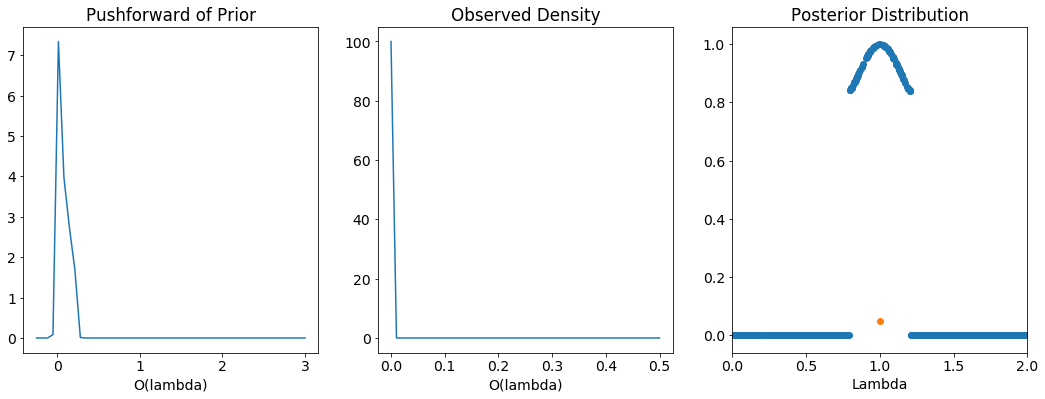

In [3]:
interact_manual(sandbox, 
        num_samples = IntSlider(value=500, 
            min=int(5E2), max=int(5E4), step=500, description='Samp. $N$ ='), 
        lam_bound = FloatRangeSlider(value=[0.0, 2.0], 
            min=-5.0, max = 5.0, step=0.25, description='Param $\Lambda \in$'),
        lam0 = FloatSlider(value=1.0, 
            min=0.25, max=1.75, step=0.05, description='IC: $\lambda_0$ ='), 
        dof = IntSlider(value=10, 
            min=1, max=50, description='d.o.f. $K$ ='), 
        T = FloatRangeSlider( value=[0.5, 1], min=0.1, max=7.5, step=0.1,
            description='$t\in [T_0, T]$:', orientation='horizontal',
            readout=True, readout_format='.1f'), 
        uncertainty = FloatSlider(value=0.01, 
            min=0.005, max=0.25, step=0.005, 
            description='Invert MSE $\leq$', readout_format='.3f'),
        sd = FloatSlider(value=1, 
            min=0.15, max=1.85, step=0.05, description='Constant $\sigma$:'));
plt.show()

---

### Suggestions

- Increase $N$ and watch the Pushforward of the Prior change/converge.
- If you broaden the standard deviation $\sigma$, we suggest to also broaden the bound on the parameter space $\Lambda$ in order to avoid voilating the predictability assumption.
- Notice the relationship between the bound on the interval we are inverting for the Mean Squared Error and the support of the posterior.
- The same happens as you increase $\sigma$.
- Change the initial condition $\lambda_0$ and watch the posterior distribution follow the slider.



- Fix the number of observations to 1 and change the interval over which the observation is being made (with $K=1$, the observation occurs only at $T_0$). Notice the diminishing returns as you wait to make your measurement. 
- Fix some interval and change the number of observations made during this time period.
- Fix a number of observations (several) and fix $T_0$ while changing $T$ to observe another example of diminshing returns.

### Observations

- Entropy barely changes as $\lambda_0$ moves around. Increases a bit near boundary of $\Lambda$ (likely due to predictability assumption being violated)
- For a wide time measurement window, entropy increases with the number of observations $K$ (d.o.f.)
- Widening $\Lambda$ decreases entropy, obviously enlarges $\mathcal{D}$, support of $P_\mathcal{D}$.
- If you narrow the window, the entropy decreases.
- As the window slides earlier in time, the entropy decreases.
- Higher MSE threshold means higher entropy.
- Higher variance means higher entropy. We might run a suite of $\sigma$s MADS-style to study the robustness of a design. 
    - perhaps if we try to minimize entropy (maximize information gain), we look for designs that are less sensitive to the choice of $\sigma$s, which would **correspond to an experimental design that is robust to measurement uncertainty.**
- Increasing the number of samples $N$ increases entropy quite a bit. Would like to figure out a way to control for this? _Is it even right to be using `scipy.stats.entropy`?_